# Generating Coordinates for TIFF-Based Kerchunk Reference Recipes

In this tutorial we will demonstrate how to use `xrefcoord` to generate coordinates for a reference dataset create using `Kerchunk`. Initially we will build a reference dataset from a collection of TIFF files using `Kerchunk`, then we will use `xrefcoord` to generate coordinates for the dataset.


## Background

When using `Kerchunk` with TIFF files, no coordinate information is saved within the reference file. Because of this, when accessing the reference dataset with `Xarray`, no coordinates are accessable and selection is only possible by dimensions. 

This utilty / `Xarray` accessor, uses geospatial metadata from the reference files attributes to generate coordinates on access time. 

## Building a Reference Dataset with Kerchunk

In [ ]:
# https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook

In [1]:
import fsspec
import requests
import glob
import numpy as np

import s3fs
import xarray as xr
from kerchunk.tiff import tiff_to_zarr
from kerchunk.combine import MultiZarrToZarr

from tempfile import TemporaryDirectory
import dask
import ujson
import xrefcoord  # noqa
from distributed import Client
import logging
import warnings


import imagecodecs.numcodecs

imagecodecs.numcodecs.register_codecs()

## Data Source

For this example, we will read a collection of TIFF files stored on `s3`. These TIFFs are from the Sentinel 2 mission and are gridded Aerosol Optical Thickness (AOT) data products.


In [2]:
# Initial an fsspec filesystem to read files over s3.
fs_read = fsspec.filesystem("s3", anon=True, skip_instance_cache=True)

# Here we use fsspec's glob feature to grab the matching files at a specified path.
files_paths = fs_read.glob("s3://sentinel-cogs/sentinel-s2-l2a-cogs/44/P/MT/2022/5/*/AOT.tif")

# Prepend 's3://'
file_pattern = sorted(["s3://" + f for f in files_paths])

### Examine a Single TIFF 
Here we are opening up a single TIFF with `Xarray` and `rioxarray`.

In [3]:
%%time

xr_ds = xr.open_dataset(file_pattern[0], chunks="auto", engine="rasterio")
xr_ds

CPU times: user 406 ms, sys: 133 ms, total: 539 ms
Wall time: 10.1 s


<xarray.Dataset>
Dimensions:      (band: 1, x: 1830, y: 1830)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4e+05 4e+05 4.001e+05 ... 5.097e+05 5.097e+05
  * y            (y) float64 1.3e+06 1.3e+06 1.3e+06 ... 1.19e+06 1.19e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>

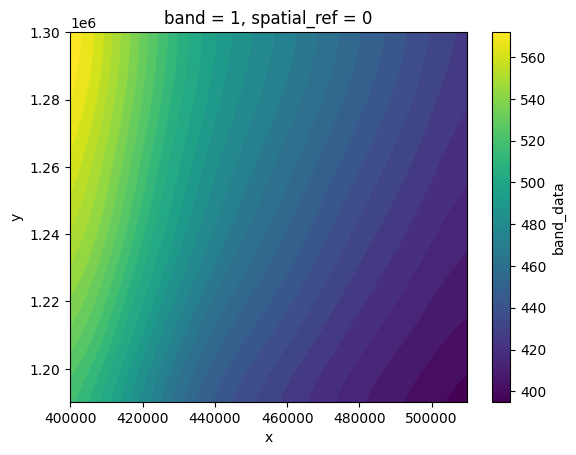

In [4]:
xr_ds.band_data.load().plot()

In [5]:
file_pattern[0]

's3://sentinel-cogs/sentinel-s2-l2a-cogs/44/P/MT/2022/5/S2A_44PMT_20220505_0_L2A/AOT.tif'

In [3]:
h5chunks = tiff_to_zarr(
    "s3://sentinel-cogs/sentinel-s2-l2a-cogs/44/P/MT/2022/5/S2A_44PMT_20220505_0_L2A/AOT.tif",
    remote_options={"protocol": "s3"},
)
# h5chunks = tiff_to_zarr('s3://silo-open-data/Recommended/daily/daily_rain/2023/20230101.daily_rain.tif', remote_options={"protocol": "s3"})

In [4]:
aot = xr.open_dataset(
    "s3://sentinel-cogs/sentinel-s2-l2a-cogs/44/P/MT/2022/5/S2A_44PMT_20220505_0_L2A/AOT.tif",
    chunks="auto",
    engine="rasterio",
)
# rain = xr.open_dataset('s3://silo-open-data/Recommended/daily/daily_rain/2023/20230101.daily_rain.tif', chunks="auto", engine="rasterio")

In [5]:
aot

<xarray.Dataset>
Dimensions:      (band: 1, x: 1830, y: 1830)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4e+05 4e+05 4.001e+05 ... 5.097e+05 5.097e+05
  * y            (y) float64 1.3e+06 1.3e+06 1.3e+06 ... 1.19e+06 1.19e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>

## Start a Dask Client for Multiprocessing
Here we will initiate a `Dask` client for parallel processing as well as specify a temporary directory for storing the references.

In [6]:
# Setup some fsspec kwargs
so = dict(mode="rb", anon=True, default_fill_cache=False, default_cache_type="first")

# Create a temp directory
td = TemporaryDirectory()
temp_dir = td.name

# Start a Dask client
client = Client(n_workers=8, silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63995,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:64016,Total threads: 1
Dashboard: http://127.0.0.1:64021/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:63998,


## Create Reference Files using Kerchunk

### Start Dask Compute

In [7]:
warnings.filterwarnings("ignore")
dask.compute(tasks)

NameError: name 'tasks' is not defined

## Combine Reference Files into Multi-File Reference Dataset

Now we will combine all the reference files generated into a single reference dataset. Since each TIFF file is a single timeslice and the only temporal information is stored in the filepath, we will have to specify the `coo_map` kwarg in `MultiZarrToZarr` to build a dimension from the filepath attributes. 



In [ ]:
# Custom Kerchunk function from `coo_map` to create dimensions
def fn_to_time(index, fs, var, fn):
    import re
    import datetime

    subst = fn.split("/")[-2].split("_")[2]
    return datetime.datetime.strptime(subst, "%Y%m%d")


mzz = MultiZarrToZarr(
    path=files_paths,
    indicts=sorted(glob.iglob(f"{temp_dir}/*.json")),
    remote_protocol="s3",
    coo_map={"time": fn_to_time},
    coo_dtypes={"time": np.dtype("M8[s]")},
    concat_dims=["time"],
    identical_dims=["X", "Y"],
)

# save translate reference in memory for later visualization
multi_kerchunk = mzz.translate()

# Write kerchunk .json record
output_fname = "AOT_combined.json"
with open(f"{output_fname}", "wb") as f:
    f.write(ujson.dumps(multi_kerchunk).encode())

## Open Combined Reference Dataset

In [11]:
fs = fsspec.filesystem(
    "reference",
    fo="AOT_combined.json",
    remote_protocol="s3",
    remote_options={"anon": True},
    skip_instance_cache=True,
)
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine="zarr")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nrhagen/Documents/carbonplan/xrefcoord/demo/AOT_combined.json/.zmetadata'

2023-07-19 14:13:04,862 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 91 MB fds: 263>>
Traceback (most recent call last):
  File "/Users/nrhagen/opt/anaconda3/envs/install/envs/xrefcoord/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/Users/nrhagen/opt/anaconda3/envs/install/envs/xrefcoord/lib/python3.10/site-packages/distributed/system_monitor.py", line 160, in update
    net_ioc = psutil.net_io_counters()
  File "/Users/nrhagen/opt/anaconda3/envs/install/envs/xrefcoord/lib/python3.10/site-packages/psutil/__init__.py", line 2114, in net_io_counters
    rawdict = _psplatform.net_io_counters()
OSError: [Errno 12] Cannot allocate memory


In [ ]:
ds

## Use `xrefcoord` to Generate Coordinates

In [ ]:
# Specify dimension names (time, y, y)
ref_ds = ds.xref.generate_coords(time_dim_name="time", x_dim_name="X", y_dim_name="Y")
ref_ds = ref_ds.rename({"0": "AOT"})

## Plot a Map

In [ ]:
ref_ds["AOT"].isel(time=0).plot()

## Create a Time-Series

In [ ]:
ref_ds["AOT"].sel(y=ref_ds.x.mean(), x=ref_ds.y.mean(), method="nearest").plot()